In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\KDEF_and_AKDEF\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

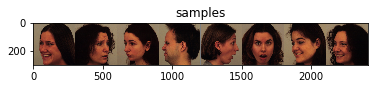

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, i=0, dataloaders=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                        outputs=outputs[0]
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/inception_'+str(i)+'.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [5]:
accuracies = []
index = list(np.random.permutation(4900))

for i in range(10):
    idx = {'val': index[490*i:490*(i+1)], 'train': index[:i*490]+index[((i+1)*490) -1:]}
    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=32,
                                             shuffle=True)
              for x in ['train', 'val']}
    
    model_ft = models.inception_v3(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

    writer = SummaryWriter('./logs/inception_full')

    model_ft, best_acc  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, i, dataloaders,
                           num_epochs=20)
    
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:29<00:00,  1.09s/it]


train Loss: 1.7494 Acc: 0.3027


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


val Loss: 1.2846 Acc: 0.5531

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.8912 Acc: 0.6975


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.5455 Acc: 0.8224

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:14<00:00,  1.03it/s]


train Loss: 0.4164 Acc: 0.8649


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.3844 Acc: 0.8673

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:18<00:00,  1.01s/it]


train Loss: 0.2561 Acc: 0.9215


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


val Loss: 0.2694 Acc: 0.9163

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:17<00:00,  1.00it/s]


train Loss: 0.1734 Acc: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.3450 Acc: 0.8796

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:19<00:00,  1.01s/it]


train Loss: 0.1228 Acc: 0.9642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


val Loss: 0.2201 Acc: 0.9204

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:22<00:00,  1.03s/it]


train Loss: 0.0790 Acc: 0.9776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


val Loss: 0.1782 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0633 Acc: 0.9832


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1771 Acc: 0.9327

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0588 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.1611 Acc: 0.9510

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0512 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1589 Acc: 0.9490

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0498 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1670 Acc: 0.9490

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0463 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.84it/s]


val Loss: 0.1531 Acc: 0.9571

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:20<00:00,  1.02s/it]


train Loss: 0.0388 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1693 Acc: 0.9449

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0393 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1691 Acc: 0.9490

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0387 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1575 Acc: 0.9510

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0388 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1600 Acc: 0.9490

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0422 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1694 Acc: 0.9449

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0422 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1553 Acc: 0.9490

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0403 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


val Loss: 0.1597 Acc: 0.9531

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:20<00:00,  1.02s/it]


train Loss: 0.0373 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


val Loss: 0.1563 Acc: 0.9531

Training complete in 48m 8s
Best val Acc: 0.957143


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9571428571428572]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:16<00:00,  1.01it/s]


train Loss: 1.7348 Acc: 0.3100


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


val Loss: 1.2743 Acc: 0.5061

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:19<00:00,  1.01s/it]


train Loss: 0.8484 Acc: 0.7079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


val Loss: 0.5461 Acc: 0.8082

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:20<00:00,  1.02s/it]


train Loss: 0.4064 Acc: 0.8671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.84it/s]


val Loss: 0.4396 Acc: 0.8347

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:18<00:00,  1.01s/it]


train Loss: 0.2521 Acc: 0.9204


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


val Loss: 0.3532 Acc: 0.8571

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:17<00:00,  1.01it/s]


train Loss: 0.1628 Acc: 0.9488


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


val Loss: 0.2807 Acc: 0.9102

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:15<00:00,  1.02it/s]


train Loss: 0.1285 Acc: 0.9608


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.2781 Acc: 0.8959

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0766 Acc: 0.9778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.2051 Acc: 0.9286

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0677 Acc: 0.9819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1998 Acc: 0.9347

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0625 Acc: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1962 Acc: 0.9327

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0506 Acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1942 Acc: 0.9286

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0535 Acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1926 Acc: 0.9327

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0447 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1866 Acc: 0.9286

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0379 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1850 Acc: 0.9306

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0423 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1853 Acc: 0.9347

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0403 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1821 Acc: 0.9367

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0373 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1735 Acc: 0.9408

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0353 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1841 Acc: 0.9306

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0403 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1929 Acc: 0.9224

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0386 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1798 Acc: 0.9367

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0449 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1833 Acc: 0.9408

Training complete in 47m 30s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7469 Acc: 0.3057


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 1.2770 Acc: 0.5306

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.8643 Acc: 0.7109


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.4904 Acc: 0.8327

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4169 Acc: 0.8578


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.4053 Acc: 0.8551

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2442 Acc: 0.9249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.2908 Acc: 0.9041

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1707 Acc: 0.9492


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.3539 Acc: 0.8735

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1360 Acc: 0.9553


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1814 Acc: 0.9306

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0763 Acc: 0.9794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1147 Acc: 0.9571

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0638 Acc: 0.9837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1200 Acc: 0.9551

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0545 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1175 Acc: 0.9551

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0539 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1069 Acc: 0.9592

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0436 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1015 Acc: 0.9694

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0416 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1010 Acc: 0.9653

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0460 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1031 Acc: 0.9653

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0438 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1023 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0408 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.0945 Acc: 0.9714

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0454 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1054 Acc: 0.9612

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0411 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.0982 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0402 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.0981 Acc: 0.9612

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0400 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.0963 Acc: 0.9673

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0413 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1021 Acc: 0.9653

Training complete in 46m 53s
Best val Acc: 0.971429



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7637 Acc: 0.2898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 1.3004 Acc: 0.5061

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.9140 Acc: 0.6803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.5614 Acc: 0.7939

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4289 Acc: 0.8574


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.3574 Acc: 0.8796

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2523 Acc: 0.9238


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.3191 Acc: 0.8898

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1744 Acc: 0.9458


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.2439 Acc: 0.9143

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1357 Acc: 0.9549


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1963 Acc: 0.9306

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0788 Acc: 0.9794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1635 Acc: 0.9490

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0610 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1587 Acc: 0.9510

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0567 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1581 Acc: 0.9469

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0528 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1535 Acc: 0.9531

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0473 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1595 Acc: 0.9490

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0467 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1566 Acc: 0.9510

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0473 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1531 Acc: 0.9510

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0437 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1503 Acc: 0.9531

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0438 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1538 Acc: 0.9490

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0407 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1541 Acc: 0.9490

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0425 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1528 Acc: 0.9510

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0426 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1523 Acc: 0.9510

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0415 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1571 Acc: 0.9490

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0406 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1522 Acc: 0.9510

Training complete in 46m 54s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7974 Acc: 0.2653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 1.3436 Acc: 0.5265

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.9498 Acc: 0.6628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.5757 Acc: 0.8000

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4630 Acc: 0.8465


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.3826 Acc: 0.8510

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2803 Acc: 0.9084


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.3073 Acc: 0.8837

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.1799 Acc: 0.9467


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.2597 Acc: 0.9000

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1430 Acc: 0.9565


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.2575 Acc: 0.9061

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0855 Acc: 0.9762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1909 Acc: 0.9245

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0666 Acc: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1714 Acc: 0.9347

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0638 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1693 Acc: 0.9429

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0560 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1759 Acc: 0.9347

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0500 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.1540 Acc: 0.9449

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0482 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1689 Acc: 0.9388

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0433 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1594 Acc: 0.9408

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0449 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1610 Acc: 0.9490

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0441 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1606 Acc: 0.9469

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0462 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1592 Acc: 0.9469

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0427 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1589 Acc: 0.9490

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0446 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1558 Acc: 0.9429

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0467 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1672 Acc: 0.9429

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0462 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


val Loss: 0.1631 Acc: 0.9429

Training complete in 46m 55s
Best val Acc: 0.948980



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7743 Acc: 0.2857


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 1.2808 Acc: 0.4653

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.8889 Acc: 0.6930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.5797 Acc: 0.8041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4339 Acc: 0.8605


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.3911 Acc: 0.8694

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2479 Acc: 0.9202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.3047 Acc: 0.9000

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1654 Acc: 0.9510


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.2429 Acc: 0.9000

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1336 Acc: 0.9615


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.2450 Acc: 0.9286

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0842 Acc: 0.9778


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1906 Acc: 0.9388

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0626 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1836 Acc: 0.9429

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0579 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1864 Acc: 0.9367

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0552 Acc: 0.9862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1808 Acc: 0.9469

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0582 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1921 Acc: 0.9347

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0551 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1753 Acc: 0.9449

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0428 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1927 Acc: 0.9490

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0397 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1706 Acc: 0.9469

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0469 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1717 Acc: 0.9429

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0418 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.1894 Acc: 0.9469

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0471 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1863 Acc: 0.9469

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0442 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1938 Acc: 0.9408

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0444 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1942 Acc: 0.9429

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0462 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1833 Acc: 0.9449

Training complete in 46m 52s
Best val Acc: 0.948980



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347, 0.9489795918367347]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7709 Acc: 0.2853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 1.3192 Acc: 0.5265

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.9515 Acc: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.6073 Acc: 0.8061

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:16<00:00,  1.01it/s]


train Loss: 0.4216 Acc: 0.8610


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.3815 Acc: 0.8571

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2505 Acc: 0.9190


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.2629 Acc: 0.8980

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1603 Acc: 0.9519


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.2383 Acc: 0.9122

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1220 Acc: 0.9630


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.2209 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0740 Acc: 0.9830


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1901 Acc: 0.9367

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0673 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1853 Acc: 0.9367

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0595 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1803 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0600 Acc: 0.9859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1882 Acc: 0.9327

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0515 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1815 Acc: 0.9388

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0488 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1762 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0463 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1821 Acc: 0.9388

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0437 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1767 Acc: 0.9408

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0431 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1756 Acc: 0.9286

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0451 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.84it/s]


val Loss: 0.1804 Acc: 0.9327

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0429 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1760 Acc: 0.9347

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0413 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1779 Acc: 0.9388

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0411 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1823 Acc: 0.9306

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0441 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1739 Acc: 0.9327

Training complete in 46m 59s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347, 0.9489795918367347, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7652 Acc: 0.3002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 1.2608 Acc: 0.5551

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.8994 Acc: 0.6932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.5374 Acc: 0.8122

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4264 Acc: 0.8585


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.3917 Acc: 0.8653

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2591 Acc: 0.9181


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


val Loss: 0.4104 Acc: 0.8490

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1689 Acc: 0.9472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.3124 Acc: 0.8857

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1298 Acc: 0.9633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.2746 Acc: 0.9102

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0756 Acc: 0.9837


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1769 Acc: 0.9327

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0709 Acc: 0.9803


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1649 Acc: 0.9388

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0582 Acc: 0.9871


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1582 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0530 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1730 Acc: 0.9327

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0502 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1851 Acc: 0.9286

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0420 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1788 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0412 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


val Loss: 0.1617 Acc: 0.9429

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0399 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1562 Acc: 0.9388

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0442 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1687 Acc: 0.9347

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0407 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1696 Acc: 0.9286

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0393 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1555 Acc: 0.9408

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0411 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1583 Acc: 0.9408

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0410 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1561 Acc: 0.9408

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0368 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1798 Acc: 0.9327

Training complete in 46m 54s
Best val Acc: 0.942857



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347, 0.9489795918367347, 0.9408163265306123, 0.942857142857143]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 1.7588 Acc: 0.3002


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 1.3141 Acc: 0.5714

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.9137 Acc: 0.6834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.5708 Acc: 0.8184

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.4346 Acc: 0.8560


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.3372 Acc: 0.8694

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.2511 Acc: 0.9240


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.4287 Acc: 0.8429

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1685 Acc: 0.9497


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.2739 Acc: 0.9143

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.1242 Acc: 0.9612


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.2240 Acc: 0.9265

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0771 Acc: 0.9814


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1811 Acc: 0.9367

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0647 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1619 Acc: 0.9429

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0583 Acc: 0.9859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.1584 Acc: 0.9469

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0554 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  2.00it/s]


val Loss: 0.1493 Acc: 0.9531

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0507 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1550 Acc: 0.9469

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0461 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


val Loss: 0.1522 Acc: 0.9429

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0414 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1511 Acc: 0.9429

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0395 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1480 Acc: 0.9469

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:12<00:00,  1.04it/s]


train Loss: 0.0492 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1622 Acc: 0.9490

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0469 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1575 Acc: 0.9388

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0385 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1523 Acc: 0.9429

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0374 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.1456 Acc: 0.9469

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0402 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1490 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0383 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1500 Acc: 0.9490

Training complete in 47m 1s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347, 0.9489795918367347, 0.9408163265306123, 0.942857142857143, 0.953061224489796]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 1.7495 Acc: 0.2941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 1.3124 Acc: 0.5143

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.8982 Acc: 0.6880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.5327 Acc: 0.8143

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.4268 Acc: 0.8603


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.3372 Acc: 0.8837

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.2552 Acc: 0.9188


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.2865 Acc: 0.9082

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.1758 Acc: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.3078 Acc: 0.8959

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.1126 Acc: 0.9678


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


val Loss: 0.2057 Acc: 0.9367

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0844 Acc: 0.9762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


val Loss: 0.1692 Acc: 0.9449

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0655 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1757 Acc: 0.9510

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0608 Acc: 0.9848


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1746 Acc: 0.9490

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0482 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1635 Acc: 0.9490

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0459 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


val Loss: 0.1651 Acc: 0.9490

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0447 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1615 Acc: 0.9510

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0423 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1626 Acc: 0.9490

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.04it/s]


train Loss: 0.0423 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.1634 Acc: 0.9510

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0404 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1607 Acc: 0.9490

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0431 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


val Loss: 0.1653 Acc: 0.9510

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0423 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.1730 Acc: 0.9531

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0388 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.1586 Acc: 0.9469

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0463 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


val Loss: 0.1729 Acc: 0.9531

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [02:13<00:00,  1.03it/s]


train Loss: 0.0429 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


val Loss: 0.1601 Acc: 0.9490

Training complete in 47m 12s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9571428571428572, 0.9408163265306123, 0.9714285714285715, 0.953061224489796, 0.9489795918367347, 0.9489795918367347, 0.9408163265306123, 0.942857142857143, 0.953061224489796, 0.953061224489796]



